## Network/Signature Analysis 
**Introduction**

https://drive.google.com/file/d/1LfPZgNb1fiMMlTJtojfjvv-1cFwJs6hY/view?usp=sharing (Links to an external site.)

The requirement here is to make a classification model that predicts if the signature is malicious by identifying or using the patterns of data traffic or application data.


**Dataset**

Dataset Location : https://drive.google.com/file/d/1LfPZgNb1fiMMlTJtojfjvv-1cFwJs6hY/view?usp=sharing

### Group 226
| Name | Bits ID | Contrubition |
| :--------------- | :--------------- | :--------------- |
| Chavhan Kalpesh Shantilal	| 2020sc04653@wilp.bits-pilani.ac.in | Equal (100%) |
| Tirth Sarkar	| 2020sc04161@wilp.bits-pilani.ac.in 	| Equal (100%) |
| Manikandan P	| 2020sc04643@wilp.bits-pilani.ac.in 	| Equal (100%) |


#### Dataset
Please change file location if required.

**Assumption** Following are categorical feature
- class protocol_type 
- flag service
- is_guest_login 
- logged_in
- root_shell
- land

In [1]:
#load dataframe from local csv
datafile = "C:\\Users\\kachavan\\Documents\\GitHub\\BITS-DSE\\Courses\\Semester01\\DM\\Signature.csv"

#load data from csv (github)
data_github = "https://raw.githubusercontent.com/KalpeshChavan12/BITS-DSE/main/Courses/Semester01/DMAssignment/Signature.csv"

### model build and evaluate implemenation 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.linear_model import SGDClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from matplotlib.pyplot import figure


import warnings
warnings.filterwarnings('ignore')

class NetworkAnalysis:

    # -------------------------------
    # init all classifier and data
    # -------------------------------
    def __init__(self, filename) -> None:
        self.names = [
            "Nearest Neighbors", 
            "Linear SVM",
            "RBF SVM",
            "Decision Tree", 
            "AdaBoost",
            "Naive Bayes", 
            "QDA",  
            "LogisticRegression"]

        # List of classifiers used building model.
        self.classifiers = [
            KNeighborsClassifier(3),
            SVC(kernel="linear", C=0.025),
            SVC(gamma=2, C=1),
            DecisionTreeClassifier(max_depth=20),
            AdaBoostClassifier(),
            GaussianNB(),
            QuadraticDiscriminantAnalysis(),
            LogisticRegression()]

        # List of classifiers used building model.
        self.classifiers_kfold = [
            KNeighborsClassifier(5),
            SVC(kernel="linear", C=0.025),
            SVC(gamma=2, C=1),
            DecisionTreeClassifier(max_depth=20),
            AdaBoostClassifier(),
            GaussianNB(),
            QuadraticDiscriminantAnalysis(),
            LogisticRegression()]

        self.df = pd.read_csv(filename)

        # Keep orignal data for backup
        self.df_org = self.df.copy()

        pass

    #--------------------------------------------------
    # Drop feature based on correlation > .9
    #--------------------------------------------------
    def DropFeatures(self, df):
        cor_matrix = df.corr().abs()
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

        self.dropped_feature = []
        for f in to_drop:
            df = self.df.drop([f], axis=1)
            self.dropped_feature.append(f)
            
    # -------------------------------
    # Outlier replacement
    # -------------------------------
    def ReplaceOutlierWithMean(self, df, col):
        
        mean = df[col].mean()

        Q3 = np.quantile(df[col], 0.75)
        Q1 = np.quantile(df[col], 0.25)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 1.5 * IQR
        upper_range = Q3 + 1.5 * IQR
        
        df[col] = np.where((df[col] > upper_range) | (df[col] < lower_range) ,mean, df[col])
        
        return df
    
    #-----------------------------------------------
    # Log tranform colum for skewed data
    #-----------------------------------------------
    def LogTranform(self, df, dryrun=True, threshold=3):
        col_names = df._get_numeric_data().columns
        skw = df.skew()
        self.log_tranform_col = []
        for c in col_names:
            if abs(skw[c]) > 3:
                if not dryrun:
                    df[c] = np.log(df[c]+1) 
                self.log_tranform_col.append(c)

    
    # -------------------------------
    # Preprocess all dataset
    # -------------------------------
    def PreProcess(self):
      
        # Drop invalid/missing value row 
        self.df.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.df = self.df.dropna()

        # Change data type and assigned code to catogorical data.
        cat_cols = ["class", 'protocol_type', 'flag', 'service', 'is_guest_login', 'logged_in', 'root_shell', 'land' ]
        for col in cat_cols:
            self.df[col] =self.df[col].astype('category').cat.codes
            self.df[col] = pd.Categorical(self.df[col])
        
        # Normalized data copy
        self.df_norm = self.df.copy()
        
        # list of numerical columns
        col_names = self.df._get_numeric_data().columns
        
        self.LogTranform(self.df_norm, False)
        
        # Normalization using Min Max [0,1].
        features = self.df_norm[col_names]
        scaler = MinMaxScaler().fit(features.values)
        features = scaler.transform(features.values)
        self.df_norm[col_names] = features
        
        # Replace Outlier with mean
        for c in col_names:
            self.df_norm = self.ReplaceOutlierWithMean(self.df_norm, c)        
        
        # PCA
        pca = PCA(n_components=2)
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.SampleData()
        
        self.X_train_pca = pca.fit_transform(self.X_train)
        self.X_test_pca = pca.transform(self.X_test)
        
        
    # -------------------------------
    # Random test train data split
    # -------------------------------
    def SampleData(self):
        x = self.df_norm.drop(['class'], axis=1)
        y = self.df_norm['class']
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=123456)
        return X_train, X_test, y_train, y_test
    
    
    # -----------------------------------------------------
    # Build and evaluate model using random test train slit.
    # ----------------------------------------------------
    def Run(self):

        log_cols=["Classifier", "Accuracy", "Prediction", "Recall", "F-Score"]
        self.log = pd.DataFrame(columns=log_cols)
        
        fig= plt.figure(figsize=(20,20))
        
        index = 0
        for clf in self.classifiers:
            
            # Train
            model = clf.fit(self.X_train_pca, self.y_train)
            name = self.names[index]

            y_score_1 =None
            b = False
            if hasattr(model, 'decision_function') : 
                y_score_1 = model.decision_function(self.X_train_pca)
                b = True
            
            # Test
            train_predictions = clf.predict(self.X_test_pca)

            # evaluate score
            acc = accuracy_score(self.y_test, train_predictions)
            prf = precision_recall_fscore_support(self.y_test, train_predictions, average="binary")

            log_entry = pd.DataFrame([[name, acc*100, prf[0]*100, prf[1]*100,prf[2]*100]], columns=log_cols)
            self.log = self.log.append(log_entry)
            
            # Pot decision region
            self.plot_decision_region(clf, index, name)
            
            index += 1
        
        plt.show()
        pass

    # -------------------------------
    # Build and evaluate model and cross validate using kFold
    # -------------------------------
    def BuildEvaluateUsingKFold(self):
        
        X = self.df_norm.drop(['class'], axis=1)
        y = self.df_norm['class'].values
        
        pca = PCA(n_components=2, svd_solver='full')
        
        X_pca = pca.fit_transform(X)
        
        fig= plt.figure(figsize=(20,20))
        
        index = 0
        splits = 20 
        kf = StratifiedKFold(n_splits=splits, shuffle=True) 
        for clf in self.classifiers_kfold:
            
            mae_train = []
            mae_test = []
            for train_index, test_index in kf.split(X_pca, y):
                X_train, X_test = X_pca[train_index], X_pca[test_index]
                y_train, y_test = y[train_index], y[test_index]   
                
                clf.fit(X_train, y_train)
                
                y_train_pred = clf.predict(X_train)
                y_test_pred = clf.predict(X_test)
                mae_train.append(mean_absolute_error(y_train, y_train_pred))
                mae_test.append(mean_absolute_error(y_test, y_test_pred))
            
            self.plot_graph_kfold(mae_train, mae_test, index, self.names[index], splits)
            index += 1
        
        plt.show()

    # -------------------------------
    # Plot graph for kfold
    # -------------------------------
    def plot_graph_kfold(self, mae_train, mae_test, index, name, splits):
        folds = range(1, splits + 1)
        
        g = plt.subplot2grid((4,4), (int(index/4),int(index%4)))
        
        g.plot(folds, mae_train, 'o-', color='green', label='train')
        g.plot(folds, mae_test, 'o-', color='red', label='test')
        g.legend()
        #g.grid()
        g.set_xlabel('Number of fold')
        g.set_ylabel('Mean Absolute Error')
        g.set_title(name)

            
    # -------------------------------
    # Plot graph decision region
    # -------------------------------
    def plot_decision_region(self, clf, index, name):
        self.plot_decision_regions(self.X_train_pca, self.y_train, clf, index = index, name=name)
    
    # -------------------------------
    # Plot graph decision region
    # -------------------------------
    def plot_decision_regions(self, X, y, classifier, resolution=0.20, index = 1, name=""):
        # setup marker generator and color map
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # plot the decision surface
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        
        g = plt.subplot2grid((4,4), (int(index/4),int(index%4)))
        g.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        g.set_xlim(xx1.min(), xx1.max())
        g.set_ylim(xx2.min(), xx2.max())

        for idx, cl in enumerate(np.unique(y)):
            g.scatter(x=X[y == cl, 0], 
                        y=X[y == cl, 1],
                        alpha=0.6, 
                        c=[cmap(idx)],
                        edgecolor='black',
                        marker=markers[idx], 
                        label=cl)# plot decision regions for training set
        
        g.set_title(name)

In [3]:
NetAnalysis = None
try:
    NetAnalysis = NetworkAnalysis(datafile)
except:
    NetAnalysis = NetworkAnalysis(data_github)

## Data set statistics

In [4]:
NetAnalysis.df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22544.000000,2.254400e+04,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,...,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,218.859076,1.039545e+04,2.056019e+03,0.000311,0.008428,0.000710,0.105394,0.021647,0.442202,0.119899,...,193.869411,140.750532,0.608722,0.090540,0.132261,0.019638,0.097814,0.099426,0.233385,0.226683
std,1407.176612,4.727864e+05,2.121930e+04,0.017619,0.142599,0.036473,0.928428,0.150328,0.496659,7.269597,...,94.035663,111.783972,0.435688,0.220717,0.306268,0.085394,0.273139,0.281866,0.387229,0.400875
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,121.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Sample data

In [5]:
NetAnalysis.df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


**Feature details and data types**

In [6]:
NetAnalysis.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

### Missing value check
Data set has some missing values we will drop rows with missing values.

In [7]:
NetAnalysis.df.isna().sum().loc[lambda x : x>0]

count        18
srv_count    13
dtype: int64

### Preprocess data
* Replace outlier with mean since data distribution is skewed.
* Normalize data using Min max scale.
* Removed feature with correaltion > .9
* Reduce dimentions using PCA (no. of components 2)
* Log transform for feature if skew > 5

##### Data Skewness details before preprocessing

In [8]:
NetAnalysis.df.skew()

duration                        15.452797
src_bytes                      117.485536
dst_bytes                       47.502505
land                            56.727418
wrong_fragment                  19.252929
urgent                          58.459562
hot                             63.456582
num_failed_logins                7.739911
logged_in                        0.232768
num_compromised                 91.496895
root_shell                      20.172940
su_attempted                    85.453186
num_root                        91.225425
num_file_creations             143.239592
num_shells                      65.657216
num_access_files                25.715871
is_guest_login                   5.674821
count                            1.909118
srv_count                        4.355689
serror_rate                      2.651837
srv_serror_rate                  2.623474
rerror_rate                      1.210648
srv_rerror_rate                  1.243352
same_srv_rate                   -1

In [9]:
NetAnalysis.PreProcess()

In [10]:
NetAnalysis.df_norm.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22523.000000,22523.000000,22523.000000,22523.000000,2.252300e+04,22523.000000,22523.000000,22523.000000,2.252300e+04,22523.000000,...,22523.000000,22523.000000,22523.000000,22523.000000,22523.000000,22523.000000,22523.000000,22523.000000,22523.000000,22523.000000
mean,0.009476,0.203397,0.255548,0.000014,1.314827e-07,0.000485,0.000194,0.000036,2.572011e-08,0.000001,...,0.760153,0.551886,0.608698,0.042139,0.030055,0.006530,0.020042,0.016007,0.113175,0.060824
std,0.021997,0.175666,0.242780,0.000214,6.238710e-06,0.002243,0.001323,0.000278,1.929865e-06,0.000029,...,0.368820,0.438358,0.435682,0.047329,0.050654,0.010862,0.039482,0.036544,0.210442,0.100305
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.470588,0.058824,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.223177,0.272816,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,1.000000,0.658824,0.920000,0.014355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.315382,0.453514,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,1.000000,1.000000,1.000000,0.084064,0.030000,0.014355,0.000000,0.000000,0.233385,0.170000
max,0.060533,0.782409,1.000000,0.003219,2.961384e-04,0.010851,0.009196,0.002190,1.448235e-04,0.000630,...,1.000000,1.000000,1.000000,0.201634,0.132250,0.028569,0.097815,0.099430,0.900000,0.420000


### Feature correlation analysis
Identify relevant, irrelevant attributes for building model. We will drop feature with correaltion > .9

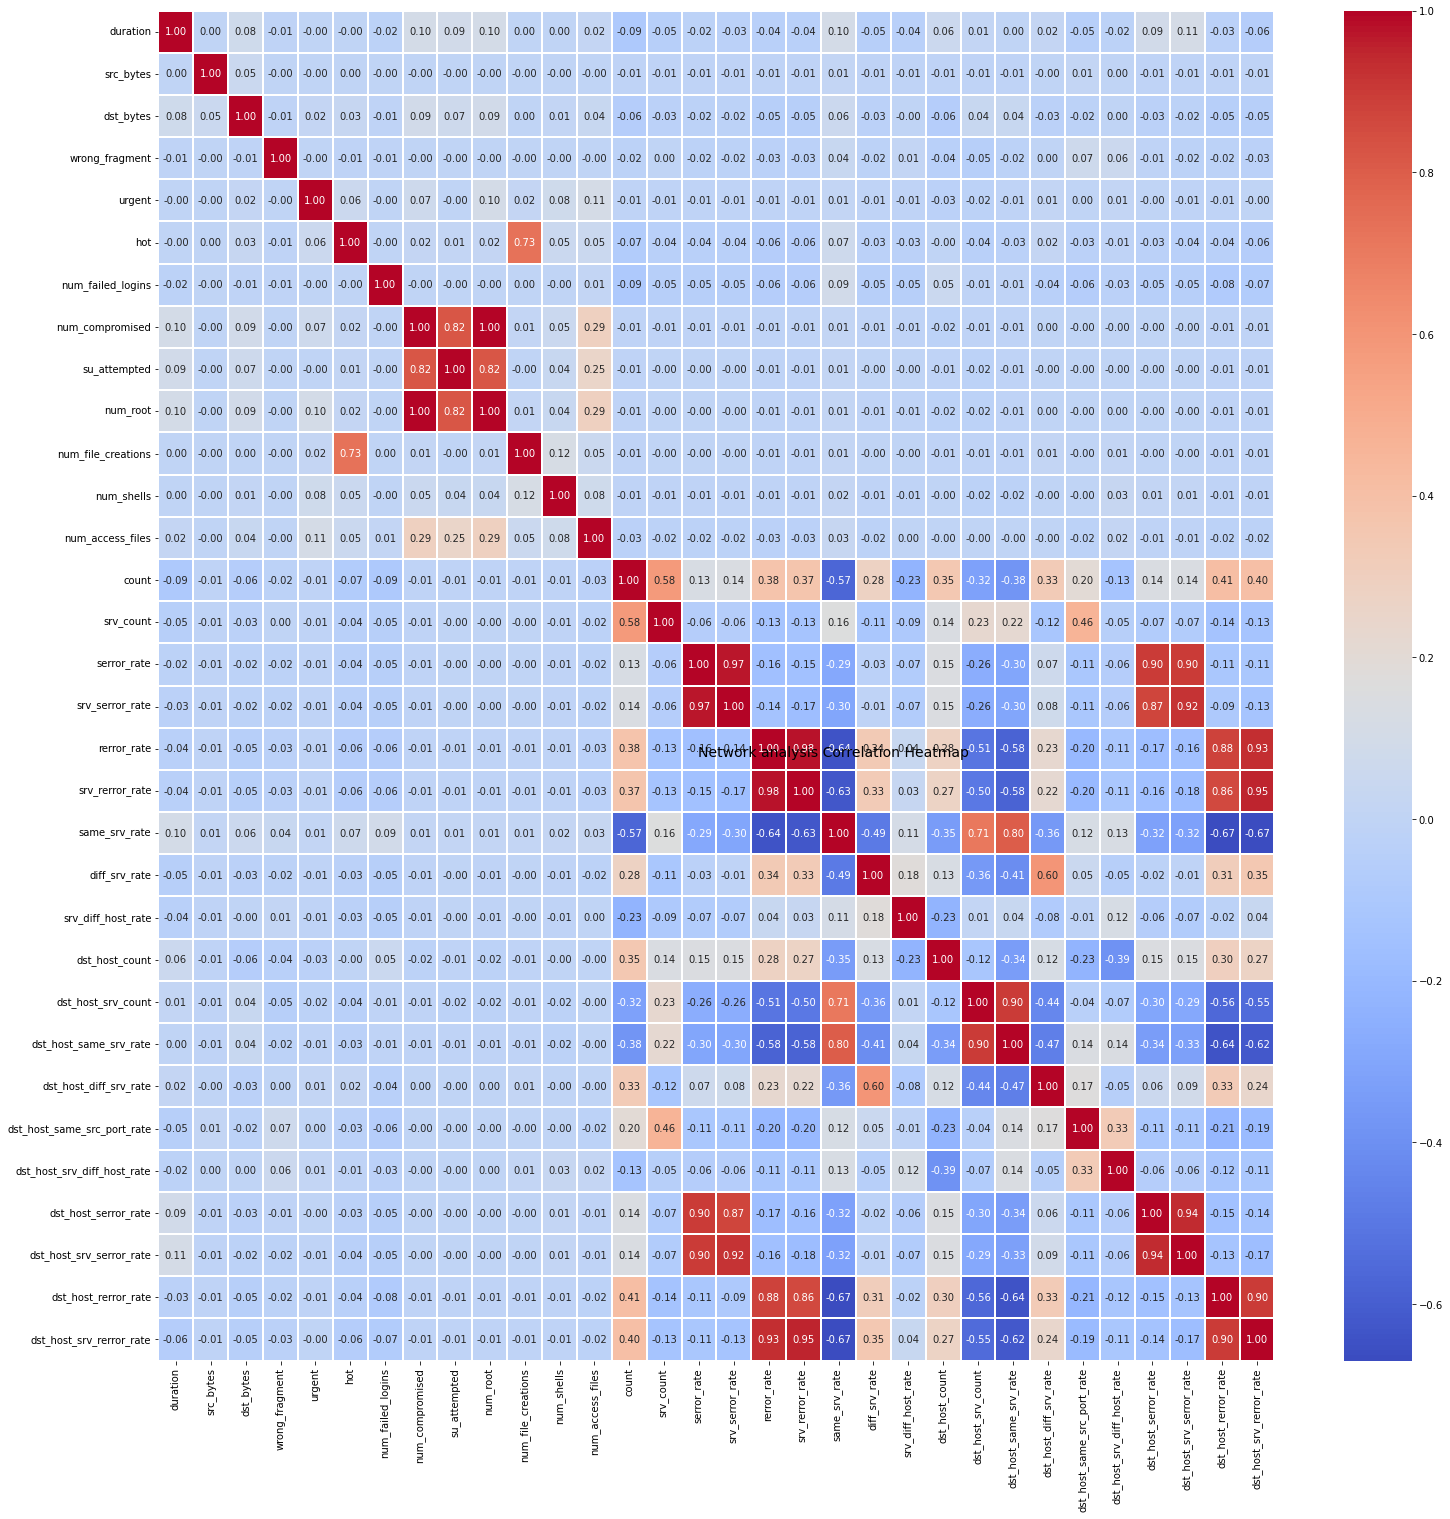

In [11]:
f, ax = plt.subplots(figsize=(25, 10))

dftmp = NetAnalysis.df.copy()
cols = NetAnalysis.df.columns

corr = dftmp.corr(method='pearson')
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.15)
f.subplots_adjust(top=2)
t= f.suptitle('Network analysis Correlation Heatmap', fontsize=14)
plt.show()

In [12]:
NetAnalysis.DropFeatures(NetAnalysis.df_norm)

In [13]:
NetAnalysis.dropped_feature

['srv_rerror_rate',
 'diff_srv_rate',
 'dst_host_same_srv_rate',
 'dst_host_srv_rerror_rate']

**Data distribuion and outliers observation using boxplot**

Data is skewed and need to normalized using log tranformer
Before Pre/processing

In [14]:
NetAnalysis.df.skew()

duration                        15.445690
src_bytes                      117.430827
dst_bytes                       47.481037
wrong_fragment                  19.243890
urgent                          58.432307
hot                             63.427851
num_failed_logins                7.757114
num_compromised                 91.454264
su_attempted                    85.413366
num_root                        91.182918
num_file_creations             143.172868
num_shells                      65.626618
num_access_files                25.703845
count                            1.908909
srv_count                        4.354883
serror_rate                      2.651743
srv_serror_rate                  2.623355
rerror_rate                      1.210629
srv_rerror_rate                  1.243364
same_srv_rate                   -1.013200
diff_srv_rate                    2.995922
srv_diff_host_rate               2.814058
dst_host_count                  -1.091227
dst_host_srv_count              -0

Skewed feature for which log tranformation applied

In [15]:
NetAnalysis.log_tranform_col

['duration',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'num_compromised',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_srv_diff_host_rate']

##### Data destribution of log transform feature before preprocessing

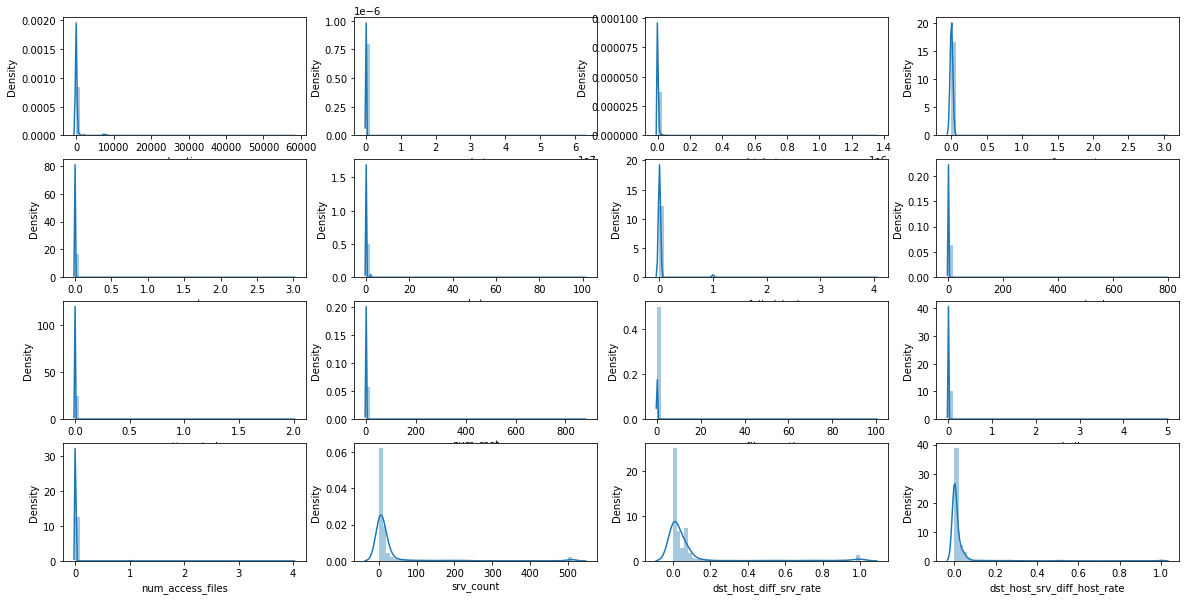

In [16]:
plt.figure(figsize=(20,10))
col_names = NetAnalysis.log_tranform_col

index=1
for c in col_names:
    plt.subplot(int(len(col_names)/4), 4, index)
    sns.distplot(NetAnalysis.df[c])
    index = index+1


##### Data distribution  after preprocessing

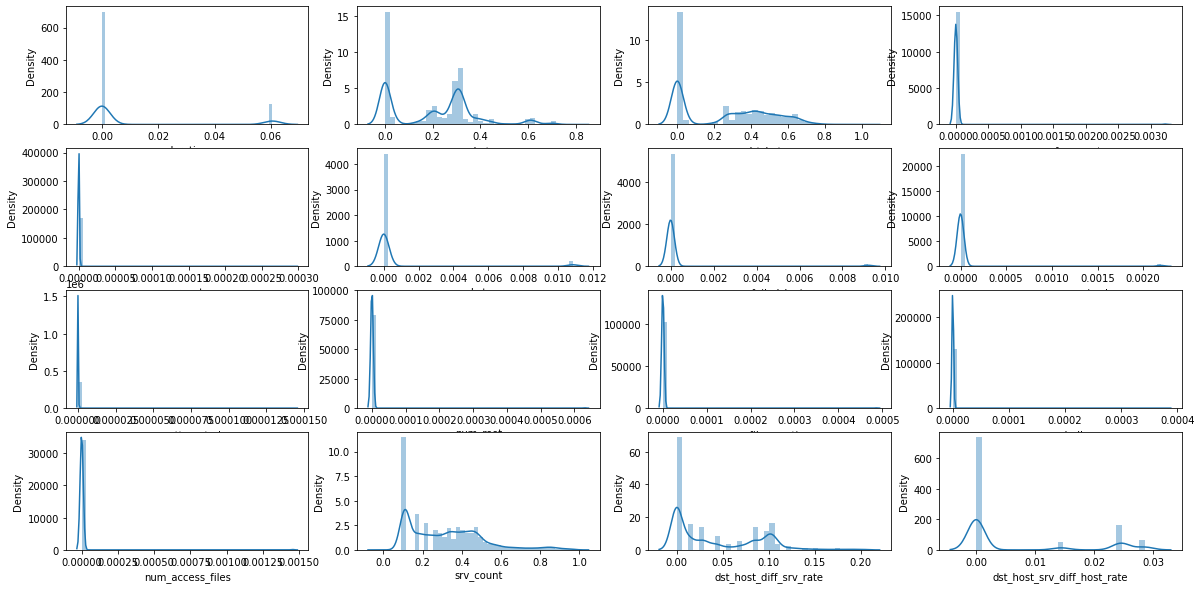

In [17]:
plt.figure(figsize=(20,10))
col_names = NetAnalysis.log_tranform_col

index=1
for c in col_names:
    plt.subplot(int(len(col_names)/4), 4, index)
    sns.distplot(NetAnalysis.df_norm[c])
    index = index+1


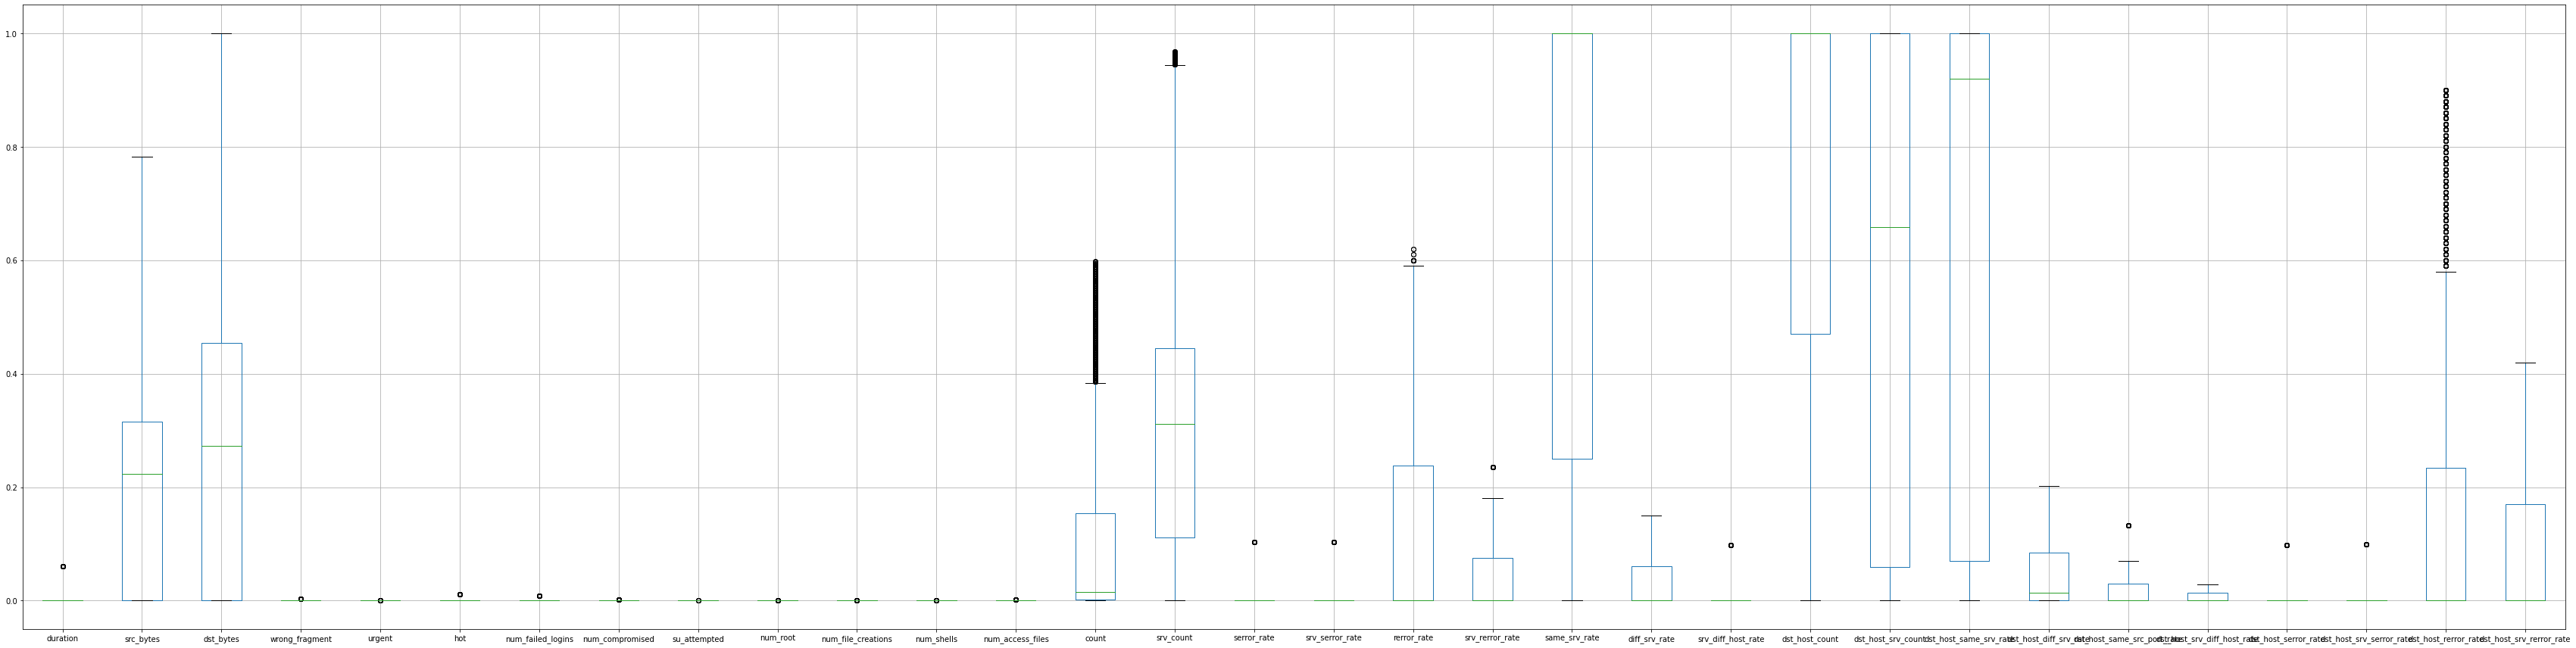

In [18]:
NetAnalysis.df_norm.boxplot()
plt.tight_layout(rect=(0, 0, 8, 3))

#### Visualize data

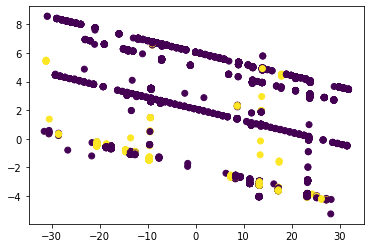

In [19]:
plt.scatter(NetAnalysis.X_train_pca[:, 0], NetAnalysis.X_train_pca[:, 1], c=NetAnalysis.y_train)

### Build and test model 
We will build and evaluate models using following classifiers 

**Model selction method:** test train random split 

**Model accurracy metrices:** Accuracy, Prediction,	Recall,	F-Score

* Nearest Neighbors
* Linear SVM
* RBF SVM
* Gaussian Process
* Decision Tree
* Random Forest
* Neural Net
* AdaBoost
* Naive Bayes
* QDA
* LogisticRegression

Graph will show decision boundires for all classifier for trained data

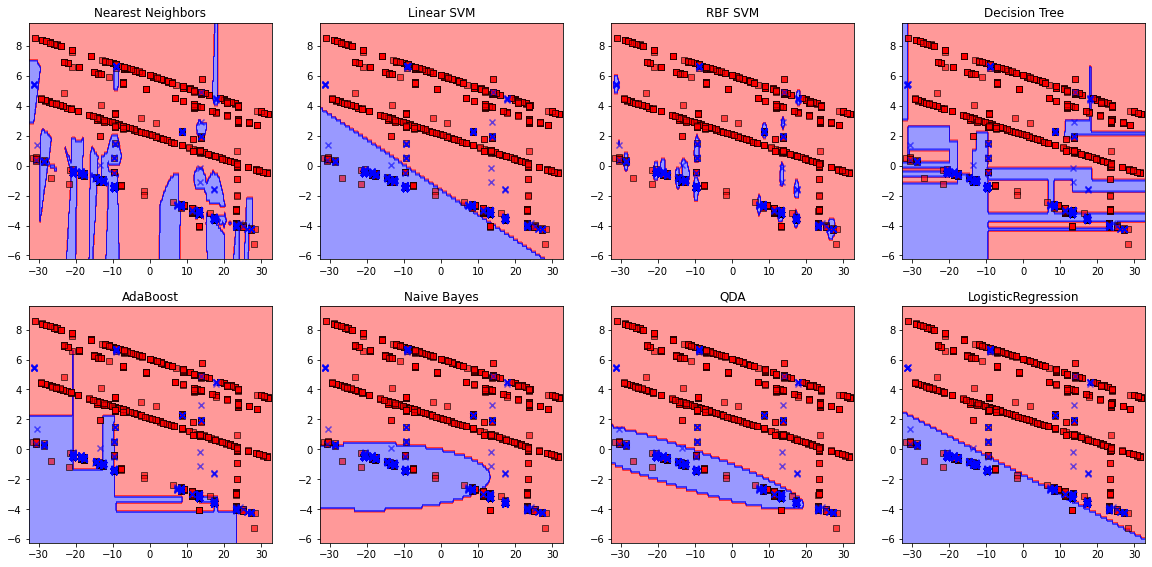

In [20]:
NetAnalysis.Run()

### Model Evaluation metrics using test data

In [21]:
NetAnalysis.log

,Classifier,Accuracy,Prediction,Recall,F-Score
0,Nearest Neighbors,94.450200,93.712680,93.156425,93.433724
0,Linear SVM,82.610626,77.445564,83.205307,80.222185
0,RBF SVM,92.156282,87.718164,94.762570,91.104397
0,Decision Tree,93.710226,92.714536,92.423184,92.568631
0,AdaBoost,92.659464,90.437158,92.458101,91.436464
0,Naive Bayes,82.329436,76.831620,83.484637,80.020080
0,QDA,80.183513,68.665851,97.939944,80.731040
0,LogisticRegression,82.595827,77.456083,83.135475,80.195352


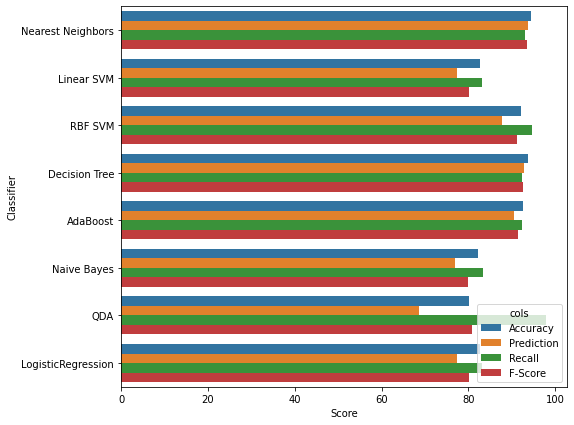

In [22]:
ig= plt.figure(figsize=(8,7))
tmpdf = NetAnalysis.log.melt('Classifier', var_name='cols', value_name='vals')
g = sns.barplot(y="Classifier", x="vals", hue='cols', data=tmpdf, orient = 'h')
g.set(xlabel='Score')
plt.show()

### Model cross verification using StratifiedKFold
We have used cross verfication using StratifiedKFold method for model selection.
A model thats fits the training set well but testing set poorly is said to be overfit to the training set and a model that fits both sets poorly is said to be underfit.

The strategy involves the following steps:

- split the dataset into training and test sets
- train the model with the training set
- test the model on the training and test sets
- calculate the **Mean Absolute Error (MAE)** for training and test sets
- plot and interpret results


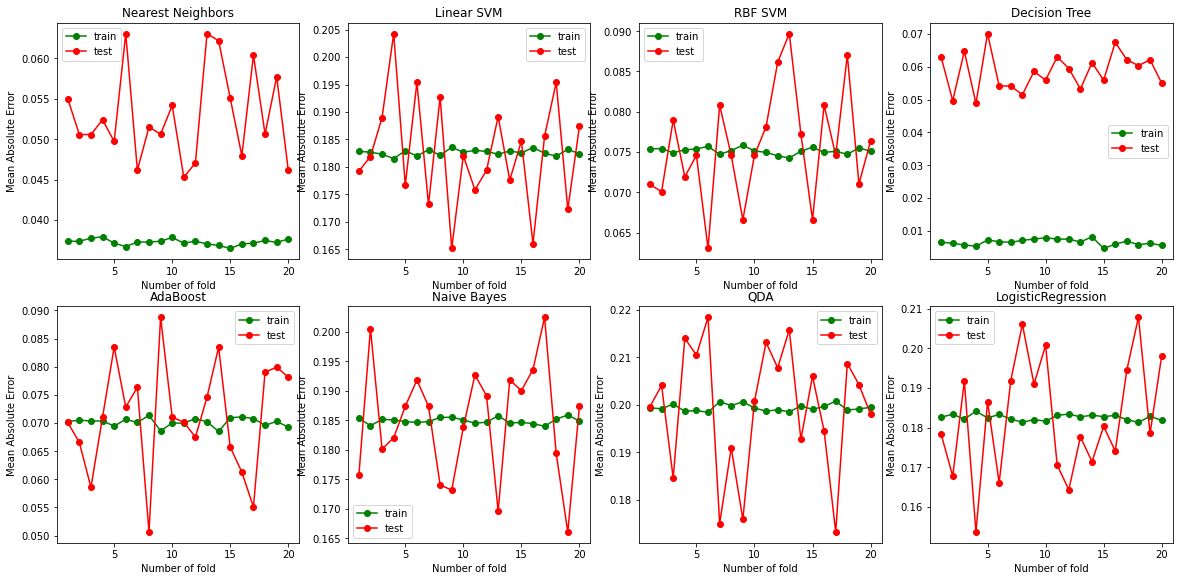

In [23]:
NetAnalysis.BuildEvaluateUsingKFold()

### Mean Absolute Error (MAE) analysis

We have observed MAE point (>.20) for **QDA,Logistic Regression**. So the model **underfits** the some portion of the **test data**. 

We have observed MAE point (<.10) for all test and training set for  **Nearest Neighbors, Decision Tree, AdaBoost and RBF SVM** SO the model is **overfits** the some portion of data. 
         
We have observed all MAE point are between .15 and .20 for **Naive Bayes, Linear SVM.**
So model is **best fit** for all portion of test and train data.



### Conclusion
**Naive Bayes, Linear SVM.** model provides simillar accuraccy, recall and f-score. it also has better MAE in KFold evaluation (i.e. < .1). These model are good choice for deployment